#### Attention

In the previous chapter, we learned about the basics:  
- **Tokenization**  
- **Input embeddings**  
- **Positional embeddings**  

We also discovered the simple formula:  

**Token embedding = Input embedding + Positional embedding**  

And from there, we even created input–output pairs.  

But now, it’s time for the next big step: **The Transformer Block**.  
At the core of this block lies the *secret sauce* of modern Large Language Models (LLMs): **Attention**.  

Why is this so important?  
Because if you *really* understand attention, you’ll understand almost every LLM out there—from BERT to GPT-4.  
And yes, if you’re sitting in an interview and can explain attention crystal clearly, you’ve already won half the battle.


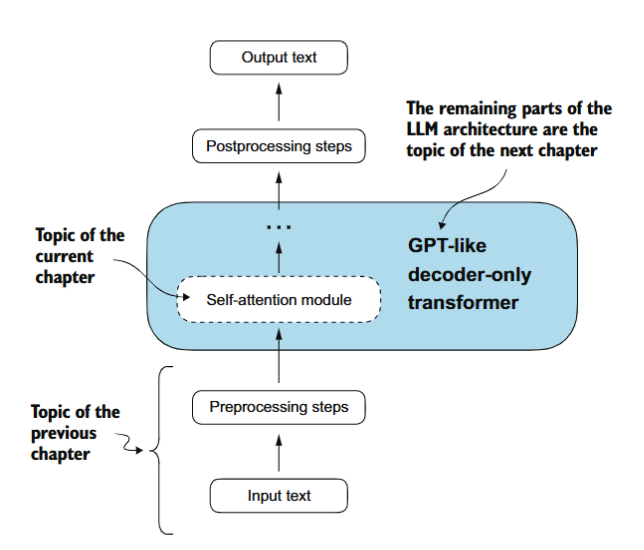

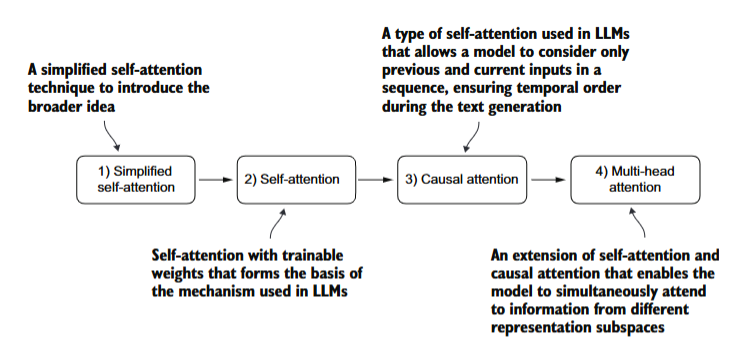

##### A Sneak Peek at GPT-2’s Transformer Block  

Inside GPT-2’s architecture, you’ll notice something called **Masked Multi-Head Attention** in every Transformer block.  

But instead of jumping directly into the most complex part, we’ll climb the ladder step by step:  

1. **Simple self-attention without trainable parameters**  
2. **Self-attention with trainable parameters**  
3. **Multi-head attention**  
4. **Multi-head attention with splits**  

By the end, you’ll be able to look at multi-head attention and say:  
*“I get you now.”*


##### But Why Attention At All?  

Think about this problem:  

Words can have multiple meanings. For example:  

- *“I went to the **bank** to withdraw money.”*  
- *“The fisherman sat by the river **bank**.”*  

We humans instantly know the two meanings are different.  
But for a machine, without **context**, the word *bank* looks the same.  

This was one of the biggest challenges in NLP.  

**Attention solves this problem**.  
It allows the model to “look around” the entire sentence and figure out the meaning of a word **based on its neighbors**.  

In short: **Attention captures context.**


##### Wrapping It Up  

So far, the roadmap looks like this:  

**Token Embedding → Attention → Contextual Embedding**  

- First, words are turned into embeddings.  
- Then, attention layers help these embeddings understand context.  
- Finally, we get **contextual embeddings**—smart word representations that know the world around them.  

Next stop: let’s actually implement attention step by step!


#### Self-Attention without any trainable parameters

**Below** we can see 6 word embeddings, let's try to catch the context.

In [ ]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

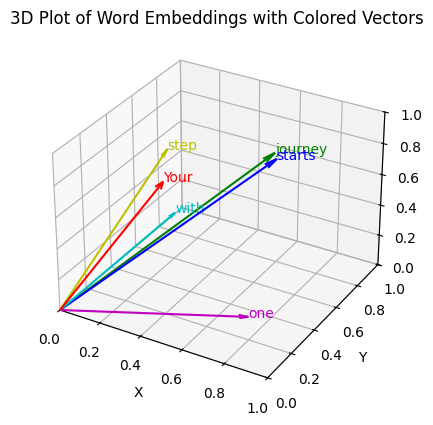

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract coordinates from the inputs tensor
x_coords = inputs[:, 0]
y_coords = inputs[:, 1]
z_coords = inputs[:, 2]

# Define the words corresponding to the embeddings
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']


# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

Imagine a sentence:  

**“Your journey starts with one step.”**  

Suppose each word has a 3D embedding (already plotted above 📊).  
Now, our target is simple but powerful:  

👉 **Turn the word embedding of “journey” into a contextual embedding.**  

But how do we do that?  

Here’s a hint: we need to capture the relationship between **“journey”** and *every other word* in the sentence:  

- (Your, journey)  
- (journey, journey)  
- (starts, journey)  
- (with, journey)  
- (one, journey)  
- (step, journey)  

So the question is: **How can we measure these relationships?**

The answer is: **dot product.**  

Think about what the dot product really means between two embeddings:  

- It’s not just math.  
- It gives us a **similarity score**.  
- In fact, it’s telling us *how much one vector is aligned with another.*  

So, the dot product gives us a measure of how “connected” two words are.  
That’s exactly what we need to build **attention scores**.  

Let’s try it out: we’ll treat the embedding of “journey” as our **query**.

In [ ]:
# Take "journey" as the query (2nd token)
query = inputs[1]

# Dot product with every other token
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print("Attention Scores:", attn_scores_2)

Attention Scores: tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


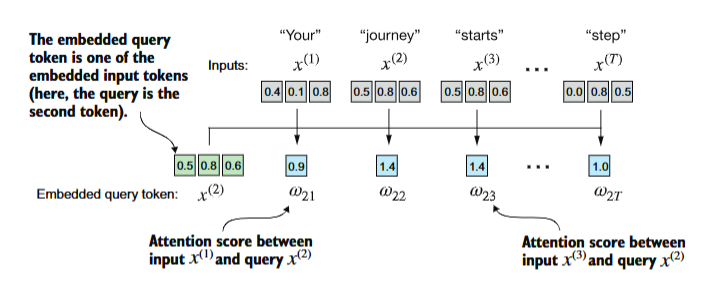

Right now, our dot products are just raw scores.  
But attention needs something better: **weights** that tell us “how much” focus to give each word.  

That’s where **Softmax** comes in.  

- Softmax squashes numbers into probabilities.  
- The values become positive and sum to 1.  
- This makes them *weights* we can apply to each word.  

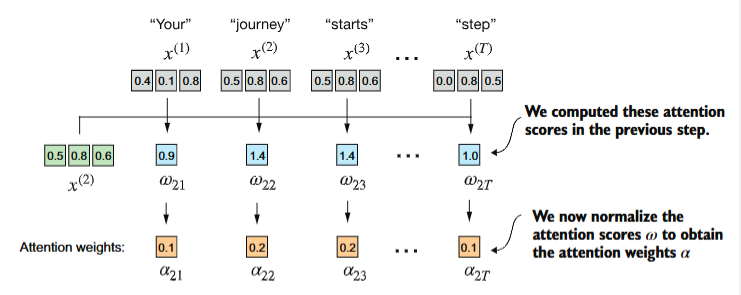

In [ ]:
# Convert scores to attention weights using softmax
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum of weights:", attn_weights_2.sum())


Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum of weights: tensor(1.)


Now comes the fun part:  

1. Multiply each word’s embedding by its attention weight.  
2. Add them all together.  

The result?  
A new vector: the **contextual embedding** for “journey.”  

In [ ]:
# Initialize empty vector for the new contextual embedding
context_vec_2 = torch.zeros(query.shape)

# Weighted sum
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

print("Contextual embedding for 'journey':\n", context_vec_2)


Contextual embedding for 'journey':
 tensor([0.4419, 0.6515, 0.5683])


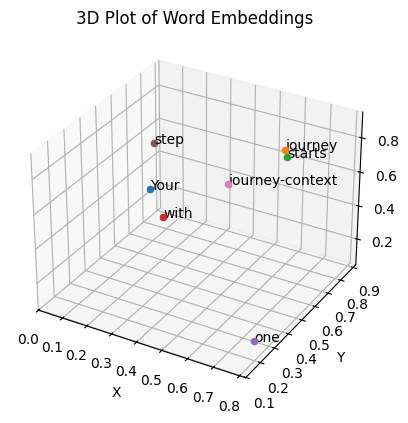

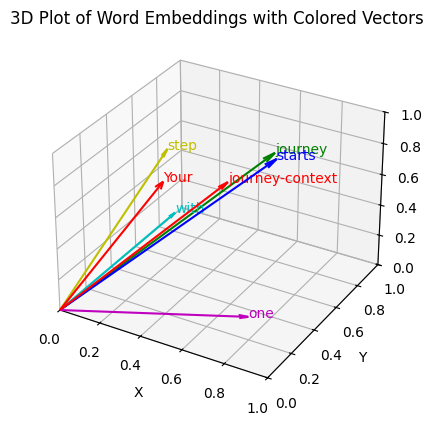

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs2 = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]
)

# Corresponding words
words2 = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs2[:, 0].numpy()
y_coords = inputs2[:, 1].numpy()
z_coords = inputs2[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words2):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words2, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

<div class="alert alert-block alert-success">

Now, we can extend this computation to
calculate attention weights and context vectors for all inputs.

</div>

In [ ]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-info">
    
When computing the preceding attention score tensor, we used for-loops in Python.
                                                            
However, for-loops are generally slow, and we can achieve the same results using matrix
multiplication:
</div>

In [ ]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-success">

We now normalize each row so that the values in
each row sum to 1:

</div>

In [ ]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


<div class="alert alert-block alert-warning">

In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies
the dimension of the input tensor along which the function will be computed.

By setting
dim=-1, we are instructing the softmax function to apply the normalization along the last
dimension of the attn_scores tensor.

If attn_scores is a 2D tensor (for example, with a
shape of [rows, columns]), dim=-1 will normalize across the columns so that the values in
each row (summing over the column dimension) sum up to 1.
    
</div>

<div class="alert alert-block alert-success">

Let's briefly verify that
the rows indeed all sum to 1:

</div>

In [ ]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


<div class="alert alert-block alert-success">

In the third and last step, we now use these attention weights to compute all context
vectors via matrix multiplication:

</div>

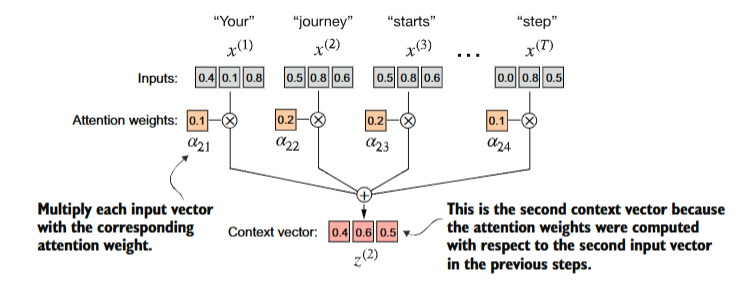

In [ ]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


<div class="alert alert-block alert-success">

We can double-check that the code is correct by comparing the 2nd row with the context
vector z(2) calculated previously

</div>

In [ ]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


<div class="alert alert-block alert-info">
    
Based on the result, we can see that the previously calculated context_vec_2 matches the
second row in the previous tensor exactly
</div>

<div class="alert alert-block alert-warning">

This concludes the code walkthrough of a simple self-attention mechanism.
    
</div>


---


#### Self-attention with trainable parameters

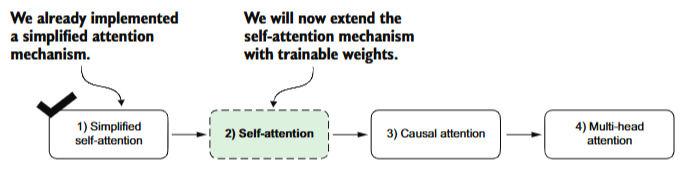

###### Looking Back: From “No Parameters” to Q, K, V  

Let’s revisit our **simple self-attention (without parameters)** and see how it already had the *pattern* of Query, Key, and Value hiding inside.  

Think about it:  
- The word **“journey”** acted as the **Query** — just like a search query in a database.  
- That query looked at **all words in the sentence** (the Keys) and asked:  
  *“How relevant are you to me?”*  
- The resulting **attention weights** were then used to combine the information (Values), giving us the updated contextual meaning of *journey*.  

---

###### How Does This Work in Real Life?  

Take the sentence:  
**“The bank of the river was flooded.”**  

When *you* read this, your brain automatically connects the dots:  
- It looks at the word *bank* (the Query).  
- It checks against other words (*river*, *flooded*) — the Keys.  
- And then, it builds the meaning (the Value): here *bank* clearly means the side of a river, not a financial institution.  

---

###### The Limitation of Simple Dot Products  

In our earlier setup:  
- **Query = each word**  
- **Key = all words**  
- **Value = weighted sum of embeddings**  

This worked, but it was too rigid. Just using raw dot products can miss subtle connections.  

For example, two words might not look similar semantically, but in a particular sentence, they *should* influence each other.  

Our brains handle this nuance naturally.  
But how can a machine learn it?  

---

###### Enter Trainable Weights  

The trick is simple but powerful:  
We introduce **three trainable weight matrices** — one each for Q, K, and V.  

- Every word embedding gets transformed three different ways:  
  - **Q = X × W_Q**  
  - **K = X × W_K**  
  - **V = X × W_V**  

This means the same word inside a sentence can now have **three different representations**,  
depending on whether it’s acting as a Query, a Key, or a Value.  

That’s how the model learns flexible, context-dependent meanings.  


***If you stuggle even now let me say in another way because it is important.***

So far, we saw how simple dot products can help us measure the relationship between words.  
But that was only the beginning.  

Now comes the next level: **self-attention with trainable weights.**  
This is where the famous trio enters the stage:  

👉 **Query (Q), Key (K), and Value (V)**  

---

###### What are Query, Key, and Value?  

The best way to think about them is to use an **analogy of searching for information in a library**:  

- **Query (Q):** This is like your **question**.  
  > Example: “Tell me everything about *journey*.”  

- **Key (K):** Keys are like the **labels on all the bookshelves**.  
  Each word in the sentence has its own “key” that says what it contains.  

- **Value (V):** Values are like the **actual content inside the books**.  
  This is the information we’ll retrieve once we’ve matched the query to the right keys.  

---

###### Another Analogy: Friend Group Chat  

Imagine you’re in a group chat with friends.  

- You (the word *journey*) want to know: *“Who’s talking about me, and how much should I listen?”*  
- **Query (Q):** That’s *your perspective*. What you want to focus on.  
- **Key (K):** Each friend introduces themselves (“I’m about food”, “I’m about travel”, “I’m about exams”).  
- **Value (V):** Each friend then shares their actual message.  

The magic:  
👉 You look at everyone’s Key, compare it with your Query, assign **attention scores**, and then collect their Values (weighted by importance).  

---

###### Why Do We Need Q, K, and V?  

In our earlier version of attention, we directly compared embeddings with dot products.  
That worked, but it was rigid.  

Now, instead of using raw embeddings, we *learn* three separate projections of each word:  

- **Q = X × W_Q**  
- **K = X × W_K**  
- **V = X × W_V**  

Here, **X** is the word embedding, and **W_Q, W_K, W_V** are trainable weight matrices.  

This gives the model flexibility to decide:  
- How to *ask questions* (Q)  
- How to *represent itself* when being asked (K)  
- How to *deliver content* (V)  

---

###### Concrete Example  

Take the sentence:  

**“The bank of the river is calm.”**  

- If we focus on the word **bank**,  
  - The **Query (Q)** for *bank* will check: *“Who among you gives me context about my meaning?”*  
  - The **Keys (K)** of *river* will strongly align with this query.  
  - The **Values (V)** of *river* will then provide the actual content that helps shape *bank*’s contextual meaning.  

End result:  
👉 The embedding of *bank* gets updated with context, and the model learns it’s about rivers, not money.  

---

###### The Flow of Information  

We can now summarize the process:  

1. Start with embeddings of all words (X).  
2. Project them into Queries, Keys, and Values using trainable weights.  
3. Compare each Query with all Keys (via dot product) → Attention Scores.  
4. Softmax → Attention Weights.  
5. Use weights to combine Values → Contextual Embeddings.  

In one line:  

👉 **Q asks, K decides relevance, V delivers the content.**

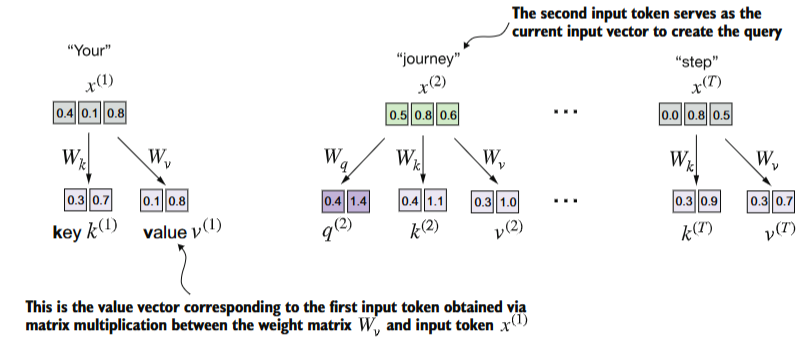

In [ ]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [ ]:
d_in = inputs.shape[1]
d_out = inputs.shape[1]
d_in, d_out

(3, 3)

In [ ]:
import torch.nn as nn

In [ ]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [ ]:
print(W_query)

Parameter containing:
tensor([[0.2961, 0.5166, 0.2517],
        [0.6886, 0.0740, 0.8665],
        [0.1366, 0.1025, 0.1841]])


<div class="alert alert-block alert-info">
    
Note that we are setting requires_grad=False to reduce clutter in the outputs for
illustration purposes.

If we were to use the weight matrices for model training, we
would set requires_grad=True to update these matrices during model training.

</div>

In [ ]:
x_2 = inputs[1]
x_2 # embedding for the word 'journey'

tensor([0.5500, 0.8700, 0.6600])

In [ ]:
query_2 = x_2 @ W_query
query_2

tensor([0.8520, 0.4161, 1.0138])

In [ ]:
key_2 = x_2 @ W_key
key_2

tensor([0.7305, 0.4227, 1.1993])

In [ ]:
value_2 = x_2 @ W_value
value_2

tensor([0.9074, 1.3518, 1.5075])

<div class="alert alert-block alert-success">

We can obtain all keys and values via matrix multiplication:
</div>

In [ ]:
queries = inputs @ W_query
keys = inputs @ W_key
values = inputs @ W_value

In [ ]:
print("keys.shape:", keys.shape)

print("values.shape:", values.shape)

print("queries.shape:", queries.shape)

keys.shape: torch.Size([6, 3])
values.shape: torch.Size([6, 3])
queries.shape: torch.Size([6, 3])


Just like the previous attention score, we can calculate the attention score of 'journey' to each word using our keys now

In [ ]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.7872, 2.0141, 2.0091, 0.9952, 1.3538, 1.1227])


In [ ]:
# Now we can do the same thing for all words at once
attn_scores = queries @ keys.T # omega
print(attn_scores)

tensor([[0.7616, 0.8765, 0.8746, 0.4349, 0.5941, 0.4877],
        [1.7872, 2.0141, 2.0091, 0.9952, 1.3538, 1.1227],
        [1.7646, 1.9901, 1.9852, 0.9834, 1.3383, 1.1091],
        [1.0664, 1.1947, 1.1916, 0.5897, 0.8004, 0.6667],
        [0.8601, 0.9968, 0.9950, 0.4947, 0.6817, 0.5516],
        [1.3458, 1.4957, 1.4915, 0.7374, 0.9968, 0.8366]])



    
We compute the attention weights by scaling the
attention scores and using the softmax function we used earlier.

The difference to earlier is
that we now scale the attention scores by dividing them by the square root of the
embedding dimension of the keys.

Note that taking the square root is mathematically the
same as exponentiating by 0.5

In [ ]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1862, 0.2123, 0.2117, 0.1179, 0.1450, 0.1269])


***Why divide by sqrt***

<div class="alert alert-block alert-warning">

Reason 1: For stability in learning

The softmax function is sensitive to the magnitudes of its inputs. When the inputs are large, the differences between the exponential values of each input become much more pronounced. This causes the softmax output to become "peaky," where the highest value receives almost all the probability mass, and the rest receive very little.

In attention mechanisms, particularly in transformers, if the dot products between query and key vectors become too large (like multiplying by 8 in this example), the attention scores can become very large. This results in a very sharp softmax distribution, making the model overly confident in one particular "key." Such sharp distributions can make learning unstable,
    
</div>

In [ ]:
import torch

# Define the tensor
tensor = torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])

# Apply softmax without scaling
softmax_result = torch.softmax(tensor, dim=-1)
print("Softmax without scaling:", softmax_result)

# Multiply the tensor by 8 and then apply softmax
scaled_tensor = tensor * 8
softmax_scaled_result = torch.softmax(scaled_tensor, dim=-1)
print("Softmax after scaling (tensor * 8):", softmax_scaled_result)

Softmax without scaling: tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
Softmax after scaling (tensor * 8): tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


Reason 2: To make the variance of the dot product stable

The dot product of  Q and K increases the variance because multiplying two random numbers increases the variance.

The increase in variance grows with the dimension.

Dividing by sqrt (dimension) keeps the variance close to 1

In [ ]:
import numpy as np

# Function to compute variance before and after scaling
def compute_variance(dim, num_trials=1000):
    dot_products = []
    scaled_dot_products = []

    # Generate multiple random vectors and compute dot products
    for _ in range(num_trials):
        q = np.random.randn(dim)
        k = np.random.randn(dim)

        # Compute dot product
        dot_product = np.dot(q, k)
        dot_products.append(dot_product)

        # Scale the dot product by sqrt(dim)
        scaled_dot_product = dot_product / np.sqrt(dim)
        scaled_dot_products.append(scaled_dot_product)

    # Calculate variance of the dot products
    variance_before_scaling = np.var(dot_products)
    variance_after_scaling = np.var(scaled_dot_products)

    return variance_before_scaling, variance_after_scaling

# For dimension 5
variance_before_5, variance_after_5 = compute_variance(5)
print(f"Variance before scaling (dim=5): {variance_before_5}")
print(f"Variance after scaling (dim=5): {variance_after_5}")

# For dimension 20
variance_before_100, variance_after_100 = compute_variance(100)
print(f"Variance before scaling (dim=100): {variance_before_100}")
print(f"Variance after scaling (dim=100): {variance_after_100}")

Variance before scaling (dim=5): 4.5986534435349835
Variance after scaling (dim=5): 0.9197306887069965
Variance before scaling (dim=100): 99.1201804431648
Variance after scaling (dim=100): 0.9912018044316481


<div class="alert alert-block alert-success">
    
We now compute the context vector as a weighted sum over the value
vectors.

Here, the attention weights serve as a weighting factor that weighs the respective
importance of each value vector.

We can use matrix multiplication to
obtain the output in one step:</div>

In [ ]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.6864, 1.0577, 1.1389])


<div class="alert alert-block alert-success">
    
So far, we only computed a single context vector, z(2).

In the next section, we will generalize the code to compute all context vectors in the input sequence, z(1)to z (T)</div>

In [ ]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [ ]:
d_in = inputs.shape[-1]
d_out = inputs.shape[-1]
torch.manual_seed(123)
attn = SelfAttention_v1(d_in, d_out)
context_embeddings = attn(inputs)
print(context_embeddings)

tensor([[0.6692, 1.0276, 1.1106],
        [0.6864, 1.0577, 1.1389],
        [0.6860, 1.0570, 1.1383],
        [0.6738, 1.0361, 1.1180],
        [0.6711, 1.0307, 1.1139],
        [0.6783, 1.0441, 1.1252]], grad_fn=<MmBackward0>)


In [ ]:
context_vec_2

tensor([0.6864, 1.0577, 1.1389])

<div class="alert alert-block alert-info">

Since inputs contains six embedding vectors, we get a matrix storing the six
context vectors, as shown in the above result.
</div>

<div class="alert alert-block alert-warning">

We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's
nn.Linear layers, which effectively perform matrix multiplication when the bias units are
disabled.

</div>

<div class="alert alert-block alert-warning">

Additionally, a significant advantage of using nn.Linear instead of manually
implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight
initialization scheme, contributing to more stable and effective model training.

</div>

In [ ]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [ ]:
torch.manual_seed(123)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[ 0.2633,  0.4277, -0.1353],
        [ 0.2641,  0.4296, -0.1350],
        [ 0.2641,  0.4296, -0.1350],
        [ 0.2647,  0.4316, -0.1381],
        [ 0.2642,  0.4303, -0.1373],
        [ 0.2648,  0.4316, -0.1375]], grad_fn=<MmBackward0>)


<div class="alert alert-block alert-info">

Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they
use different initial weights for the weight matrices since nn.Linear uses a more
sophisticated weight initialization scheme.
    
</div>

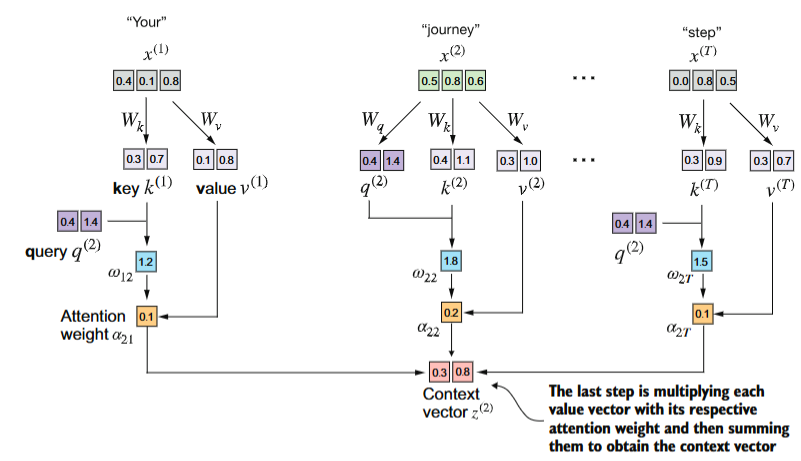

In another way we can illustrate it like this

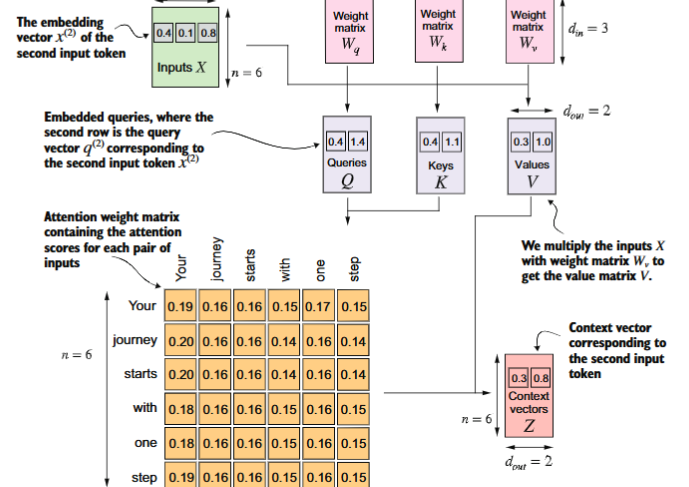

---

----

#### HIDING FUTURE WORDS WITH CAUSAL ATTENTION

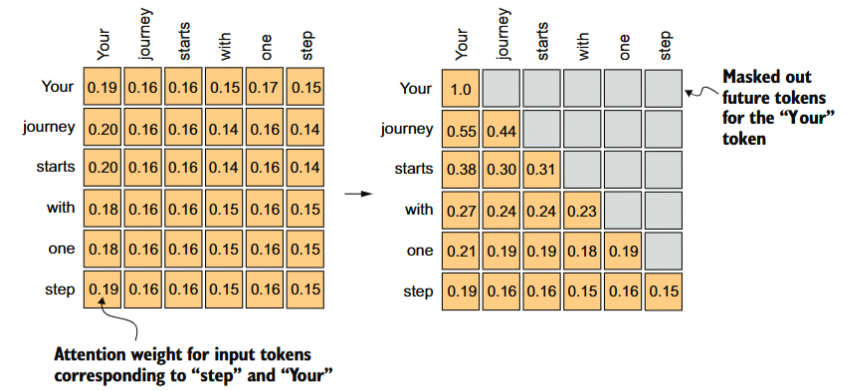

Before we dive into the code, let’s answer a simple question:  

**Why do we need masking in the first place?**  

Think of how we humans read a sentence:  
- When you’re at word #3, you don’t magically peek into the future words.  
- You only know the words that came before (and the current word).  

But without masking, the model would *cheat* — it could look ahead at words that haven’t been generated yet.  
This would leak information and break the whole idea of generating text step by step.  

So masking is like putting on **blinders** — forcing the model to only look at the past and the present, never the future.  

That’s why in GPT-style models, we use **causal attention** (also called *masked self-attention*).  

we can use a neat trick with **-∞ (negative infinity)**.  

Here’s how it works:  
- Create a mask of ones above the diagonal (the “forbidden” spots).  
- Replace those ones with **-∞**.  
- When softmax sees **-∞**, it turns it into 0 probability automatically.  

In [ ]:
# this was the previous implementation
torch.manual_seed(123)
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1466, 0.1642, 0.1642, 0.1784, 0.1686, 0.1780],
        [0.1365, 0.1743, 0.1743, 0.1727, 0.1685, 0.1737],
        [0.1368, 0.1742, 0.1741, 0.1728, 0.1685, 0.1737],
        [0.1494, 0.1725, 0.1725, 0.1686, 0.1677, 0.1694],
        [0.1497, 0.1691, 0.1690, 0.1720, 0.1680, 0.1723],
        [0.1456, 0.1743, 0.1743, 0.1685, 0.1678, 0.1694]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
print(attn_scores)

tensor([[-0.4028, -0.2063, -0.2069, -0.0635, -0.1611, -0.0672],
        [-0.2623,  0.1610,  0.1602,  0.1450,  0.1019,  0.1546],
        [-0.2630,  0.1553,  0.1546,  0.1416,  0.0979,  0.1510],
        [-0.0989,  0.1501,  0.1497,  0.1111,  0.1010,  0.1183],
        [-0.2004,  0.0102,  0.0098,  0.0397, -0.0013,  0.0425],
        [-0.1048,  0.2070,  0.2065,  0.1480,  0.1407,  0.1575]],
       grad_fn=<MmBackward0>)


In [ ]:
context_length = 6
torch.ones(context_length, context_length)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [ ]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [ ]:
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
masked

tensor([[-0.4028,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.2623,  0.1610,    -inf,    -inf,    -inf,    -inf],
        [-0.2630,  0.1553,  0.1546,    -inf,    -inf,    -inf],
        [-0.0989,  0.1501,  0.1497,  0.1111,    -inf,    -inf],
        [-0.2004,  0.0102,  0.0098,  0.0397, -0.0013,    -inf],
        [-0.1048,  0.2070,  0.2065,  0.1480,  0.1407,  0.1575]],
       grad_fn=<MaskedFillBackward0>)

In [ ]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4392, 0.5608, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2820, 0.3591, 0.3589, 0.0000, 0.0000, 0.0000],
        [0.2253, 0.2602, 0.2601, 0.2544, 0.0000, 0.0000],
        [0.1809, 0.2043, 0.2042, 0.2078, 0.2029, 0.0000],
        [0.1456, 0.1743, 0.1743, 0.1685, 0.1678, 0.1694]],
       grad_fn=<SoftmaxBackward0>)


**Important Intuition**  

Masking ensures that:  
- A word never cheats by looking at future words.  
- Attention weights only consider *themselves and the past*.  
- Softmax makes sure everything is still a proper probability distribution.  


---

After this step, the architecture follows to implement **dropouts**.

Even with masking, models can **overfit** — they may rely too heavily on certain connections.  
To fight this, we add **dropout** on top of the attention weights.  

Dropout randomly “drops” some connections (sets them to zero) during training,  
forcing the model to not rely on any single path too much.  

Think of it like training with distractions:  
the model learns to be flexible because sometimes its favorite connection is missing.  

<div class="alert alert-block alert-info">

When applying dropout to an attention weight matrix with a rate of 50%, half of the
elements in the matrix are randomly set to zero.

To compensate for the reduction in active
elements, the values of the remaining elements in the matrix are scaled up by a factor of
1/0.5 =2.

This scaling is crucial to maintain the overall balance of the attention weights,
ensuring that the average influence of the attention mechanism remains consistent during
both the training and inference phases.
</div>

In [ ]:
# Dropout example
example = torch.ones(6, 6)

torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)

print("Before dropout:\n", example)
print("After dropout:\n", dropout(example))

Before dropout:
 tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
After dropout:
 tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [ ]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5640, 0.7181, 0.7178, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5203, 0.5202, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4085, 0.0000, 0.4155, 0.0000, 0.0000],
        [0.0000, 0.3487, 0.3486, 0.3370, 0.3356, 0.0000]],
       grad_fn=<MulBackward0>)


In [ ]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [ ]:
# IMPLEMENTING A COMPACT CAUSAL ATTENTION CLASS
class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout) # New
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

  def forward(self, x):
      b, num_tokens, d_in = x.shape # New batch dimension b
      keys = self.W_key(x)
      queries = self.W_query(x)
      values = self.W_value(x)

      attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
      attn_scores.masked_fill_(  # New, _ ops are in-place
          self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
      attn_weights = torch.softmax(
          attn_scores / keys.shape[-1]**0.5, dim=-1
      )
      attn_weights = self.dropout(attn_weights) # New

      context_vec = attn_weights @ values
      return context_vec

In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in = batch.shape[-1]
d_out = d_in
ca = CausalAttention(d_in, d_out, context_length, 0.1)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)
print(context_vecs)

context_vecs.shape: torch.Size([2, 6, 3])
tensor([[[ 0.3696,  0.6288, -0.3479],
         [ 0.3840,  0.6278, -0.2486],
         [ 0.3822,  0.6227, -0.2222],
         [ 0.3447,  0.5490, -0.1785],
         [ 0.2700,  0.4763, -0.1825],
         [ 0.2942,  0.4795, -0.1528]],

        [[ 0.3696,  0.6288, -0.3479],
         [ 0.2217,  0.3516, -0.0957],
         [ 0.3822,  0.6227, -0.2222],
         [ 0.3447,  0.5490, -0.1785],
         [ 0.1893,  0.3482, -0.1476],
         [ 0.2253,  0.3970, -0.1513]]], grad_fn=<UnsafeViewBackward0>)


#### MultiHead Attention

We will now describe the forward pass of **Multi-Head Attention**, step by step, while keeping track of **tensor dimensions**.

---

**Step 1: Input**

Input tensor `x` has shape:(b, num_tokens, d_in)

where:  
- **b** = batch size  
- **num_tokens** = sequence length  
- **d_in** = input embedding dimension  

---

**Step 2: Linear projections for Q, K, V**

We apply 3 linear layers to create Queries, Keys, and Values (where W_Q, K, V were dimension of d_in, d_out):
- Q = W_Q * x      
- K = W_K * x
- V = W_V * x

Each has shape: (b, num_tokens, d_out)


---

**Step 3: Split into heads**

We divide `d_out` into multiple heads:
head_dim = d_out / num_heads

Reshape:
(b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

Then transpose:
(b, num_heads, num_tokens, head_dim)


---

**Step 4: Compute attention scores**

For each head:

scores = Q @ K^T

Dimensions:
(b, num_heads, num_tokens, num_tokens)


---

**Step 5: Apply causal mask**
- Prevent attention to future tokens using an **upper-triangular mask**  
- Fill masked positions with `-inf`  
- Apply softmax: attn_weights = softmax(scores / sqrt(head_dim))

Shape:(b, num_heads, num_tokens, num_tokens)


---

**Step 6: Weighted sum with Values**

context = attn_weights @ V

Shape:
(b, num_heads, num_tokens, head_dim)

Transpose back:
(b, num_tokens, num_heads, head_dim)


---

**Step 7: Concatenate heads**

Flatten last two dims: (b, num_tokens, num_heads * head_dim) = (b, num_tokens, d_out)
So technically, we could stop here.
But in practice, Multi-Head Attention includes one more linear layer (called out_proj in your code)


---

**Step 8: Final linear projection**

output = W_O * concatenated_heads

Final shape:
(b, num_tokens, d_out)

- **Mixing information across heads:** After concatenating, each token’s representation is just the heads placed side by side. A final linear projection lets the model recombine these different “views” into a single, unified embedding.


---

 **Summary**
1. Project input → Q, K, V  
2. Split into heads  
3. Compute scaled dot-product attention with mask  
4. Apply attention weights to Values  
5. Concatenate heads  
6. Apply final projection  

 Each token is updated with information from all tokens, captured from **multiple perspectives (heads)**.







In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-success">

The splitting of the query, key, and value tensors, is achieved
through tensor reshaping and transposing operations using PyTorch's .view and
.transpose methods.

The input is first transformed (via linear layers for queries, keys, and
values) and then reshaped to represent multiple heads.

</div>

<div class="alert alert-block alert-success">

The key operation is to split the d_out dimension into num_heads and head_dim, where
head_dim = d_out / num_heads.

This splitting is then achieved using the .view method: a
tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens,
num_heads, head_dim).
</div>

<div class="alert alert-block alert-success">

The tensors are then transposed to bring the num_heads dimension before the
num_tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim).

This transposition is crucial for correctly aligning the queries, keys, and values across the
different heads and performing batched matrix multiplications efficiently.
</div>

<div class="alert alert-block alert-success">

To illustrate this batched matrix multiplication, suppose we have the following example
tensor:

</div>

<div class="alert alert-block alert-warning">

Continuing with MultiHeadAttention, after computing the attention weights and context
vectors, the context vectors from all heads are transposed back to the shape (b,
num_tokens, num_heads, head_dim).

These vectors are then reshaped (flattened) into the
shape (b, num_tokens, d_out), effectively combining the outputs from all heads

</div>

<div class="alert alert-block alert-warning">

Additionally, we added a so-called output projection layer (self.out_proj) to
MultiHeadAttention after combining the heads, which is not present in the
CausalAttention class.

This output projection layer is not strictly necessary, but it is commonly used in many LLM
architectures, which is why we added it here for completeness.

</div>

<div class="alert alert-block alert-warning">

Even though the MultiHeadAttention class looks more complicated than the
MultiHeadAttentionWrapper due to the additional reshaping and transposition of tensors,
it is more efficient.

The reason is that we only need one matrix multiplication to compute
the keys, for instance, keys = self.W_key(x) (the same is true for the queries and
values).
                                              

In the MultiHeadAttentionWrapper, we needed to repeat this matrix multiplication,
which is computationally one of the most expensive steps, for each attention head.

</div>

<div class="alert alert-block alert-success">

The MultiHeadAttention class can be used similar to the SelfAttention and
CausalAttention classes we implemented earlier:
</div>

In [ ]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

batch_size, context_length, d_in = batch.shape
d_out = 4
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.0903,  0.5205, -0.3216,  0.5317],
         [ 0.1708,  0.5399, -0.2854,  0.4249],
         [ 0.1818,  0.5396, -0.2860,  0.4306]],

        [[ 0.0903,  0.5205, -0.3216,  0.5317],
         [ 0.1708,  0.5399, -0.2854,  0.4249],
         [ 0.1818,  0.5396, -0.2860,  0.4306]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 4])


<div class="alert alert-block alert-info">

As we can see based on the results, the output dimension is directly controlled by the
d_out argument:

</div>

<div class="alert alert-block alert-warning">

In this section, we implemented the MultiHeadAttention class that we will use in the
upcoming sections when implementing and training the LLM itself.


Note that while the code is fully functional, we used relatively small embedding sizes and numbers of attention
heads to keep the outputs readable.

</div>

<div class="alert alert-block alert-warning">

For comparison, the smallest GPT-2 model (117 million parameters) has 12 attention
heads and a context vector embedding size of 768.

The largest GPT-2 model (1.5 billion
parameters) has 25 attention heads and a context vector embedding size of 1600.

Note
that the embedding sizes of the token inputs and context embeddings are the same in GPT
models (d_in = d_out).

</div>

Created by **Md. Shadikur Rahman Sheam**.
- [Linkedin](https://www.linkedin.com/in/md-shadikur-rahman-sheam-3826482b3/)
- [Github](https://github.com/sadikurSenpai)
- [Facebook](https://www.facebook.com/profile.php?id=100091833665881)

Special thanks to Sebastian Raschka for his amazing book.